In [ ]:
# A multi layer epithelium

Consisting of stacked 2D sheets


In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pylab as plt
try:
    import seaborn as sns
except ImportError:
    print('Seaborn not found')
%matplotlib inline
from IPython.display import display

from tyssue import Sheet, MultiSheet, MultiSheetGeometry
from tyssue.dynamics import MultiSheetModel
from tyssue.solvers.multisheetsolver import MultiSheetSolver
from tyssue.dynamics import PlanarModel
from tyssue import config

from tyssue.draw.plt_draw import quick_edge_draw

from tyssue.core.generation import hexa_grid2d, from_2d_voronoi
from tyssue.utils.utils import spec_updater
from scipy.spatial import Voronoi
from tyssue.draw.threejs_draw import view_3js

import seaborn as sns



`Rbf` provides a class for radial basis function approximation/interpolation of n-dimensional scattered data, use to compute the distance between two sheets of the `MultiSheet`

### Parameters

* `*args`: arrays
    x, y, z, ..., d, where x, y, z, ... are the coordinates of the nodes
    and d is the array of values at the nodes
* `function`: str or callable, optional
    The radial basis function, based on the radius, r, given by the norm
    (default is Euclidean distance); the default is 'multiquadric':
```
        'multiquadric': sqrt((r/self.epsilon)**2 + 1)
        'inverse': 1.0/sqrt((r/self.epsilon)**2 + 1)
        'gaussian': exp(-(r/self.epsilon)**2)
        'linear': r
        'cubic': r**3
        'quintic': r**5
        'thin_plate': r**2 * log(r)
```


In [2]:
specs = config.geometry.flat_sheet()
specs['face']['layer'] = 0
specs['vert']['layer'] = 0
specs['vert']['depth'] = 0.0
specs['edge']['layer'] = 0

## Interpolation arguments
specs['settings']['interpolate'] = {'function': 'gaussian',
                                    'epsilon': 1e-4}


In [3]:
layer_args = [(24, 24, 1, 1, 0.4),
              (16, 16, 2, 2, 1),
              (24, 24, 1, 1, 0.4),
              (24, 24, 1, 1, 0.4)]
dz = 1.0

layer_datasets = []
for i, args in enumerate(layer_args):
    centers = hexa_grid2d(*args)
    data = from_2d_voronoi(Voronoi(centers))
    data['vert']['z'] = i * dz
    layer_datasets.append(data)


In [4]:
msheet = MultiSheet('more',
                    layer_datasets,
                    specs)
MultiSheetGeometry.update_all(msheet)

bbox = [[0, 25], [0, 25]]
for sheet in msheet:
    edge_out = sheet.cut_out(bbox, coords=['x', 'y'])
    sheet.remove(edge_out)
    sheet.sanitize()

In [5]:
print([np.all(np.isfinite(sheet.edge_df[sheet.dcoords])) for sheet in msheet])
print([np.all(np.isfinite(sheet.vert_df[sheet.coords])) for sheet in msheet])
print([np.all(np.isfinite(sheet.face_df[sheet.coords])) for sheet in msheet])

[True, True, True, True]
[True, True, True, True]
[True, True, True, True]


In [6]:
palette = sns.color_palette("Set1", n_colors=len(msheet), desat=.5)

def msheet_view(msheet, phi, psi, theta, ax=None, **kwargs):

    palette = sns.color_palette("Set1", n_colors=len(msheet), desat=.5)
    cos_phi = np.cos(phi)
    sin_phi = np.sin(phi)
    cos_psi = np.cos(psi)
    sin_psi = np.sin(psi)
    cos_theta = np.cos(theta)
    sin_theta = np.sin(theta)

    rotation = np.array([[cos_psi*cos_phi - sin_psi*cos_theta*sin_phi,
                          -cos_psi*sin_phi - sin_psi*cos_theta*cos_phi,
                          sin_psi*sin_theta],
                         [sin_psi*cos_phi + cos_psi*cos_theta*sin_phi,
                          -sin_psi*sin_phi + cos_psi*cos_theta*cos_phi,
                          -cos_psi*sin_theta],
                         [sin_theta*sin_phi,
                          sin_theta*cos_phi,
                          cos_theta]])
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = ax.get_figure()
    
    for sheet, color in zip(msheet, palette):
 
        rotated = np.dot(sheet.vert_df[sheet.coords], rotation)
        sheet.vert_df['rx'] = rotated[:, 0]
        sheet.vert_df['ry'] = rotated[:, 1]
        sheet.edge_df['drx'] = (sheet.upcast_trgt(sheet.vert_df['rx'])
                                - sheet.upcast_srce(sheet.vert_df['rx']))
        sheet.edge_df['dry'] = (sheet.upcast_trgt(sheet.vert_df['ry'])
                                - sheet.upcast_srce(sheet.vert_df['ry']))
        
        fig, ax = quick_edge_draw(sheet, coords=['rx', 'ry'], ax=ax, c=color, **kwargs)
    return fig, ax

(-12, 0)

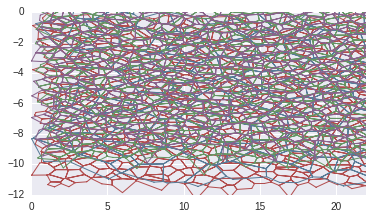

In [7]:
%matplotlib inline
fig, ax = msheet_view(msheet, psi=0, phi=0, 
                      theta=2*np.pi/3, ax=None, linewidth=1)
ax.set_xlim(0, 22)
ax.set_ylim(-12, 0)

In [11]:
grp_sheet = Sheet('grped',
                  msheet.concat_datasets(),
                  msheet[0].specs)

center = sheet.vert_df[grp_sheet.coords].mean()
for c in grp_sheet.coords:
    grp_sheet.vert_df[c] -= center[c]

renderer, line = view_3js(grp_sheet)
display(renderer)

In [12]:
mod_specs = {
    'edge': {
        'anchor_tension': 0.12,
        'line_tension': 0.12
        },
     'face': {
        'contractility': 0.04,
        'prefered_area': 1.0,
        'prefered_vol': 0.0,
        'area_elasticity': 1.0
        },
     'settings': {
        'grad_norm_factor': 1.0,
        'nrj_norm_factor': 1.0
        },
     'vert': {
        'radial_tension': 0.0,
        'prefered_height': 1.0,
        'prefered_depth': 1.0,
        'd_elasticity': 1.0,
        'u_elasticity': 1.0}}

layers_mod_specs = [
    {'face': {'prefered_area': 1.}},
    {'face': {'prefered_area': 4.}},
    {'face': {'prefered_area': 1.}},
    {'face': {'prefered_area': 1.}}]

for sheet, spec in zip(msheet, 
                       layers_mod_specs):
    
    spec_updater(mod_specs, spec)
    sheet.update_specs(MultiSheetModel.dimentionalize(mod_specs),
                       reset=True)


In [13]:
MultiSheetModel.compute_energy(msheet)

25822.131621651242

In [14]:
grads = MultiSheetModel.compute_gradient(msheet)

In [15]:
[np.all(np.isfinite(grad)) for grad in grads]

[True, True, True, True]

In [16]:
pos_idxs = [sheet.vert_df[sheet.vert_df['is_active']==1].index
            for sheet in msheet]
res = MultiSheetSolver.find_energy_min(msheet, MultiSheetGeometry,
                                       MultiSheetModel, pos_idxs)
print(res['success'])

True


In [23]:
grp_sheet = Sheet('grped',
                  msheet.concat_datasets(),
                  msheet[0].specs)

center = sheet.vert_df[grp_sheet.coords].mean()
for c in grp_sheet.coords:
    grp_sheet.vert_df[c] -= center[c]

renderer, line = view_3js(grp_sheet)
display(renderer)

In [32]:
def gauss2d(x, y, x0, y0, A, wx, wy):
    
    return A * (np.exp(-((x - x0)**2) / wx**2)
                * np.exp(-((y - y0)**2) / wy**2))

msheet[0].vert_df['basal_shift'] = gauss2d(
    msheet[0].vert_df['x'],
    msheet[0].vert_df['y'],
    x0=10, y0=10, A=4.1,
    wx=4, wy=3) - 1

MultiSheetGeometry.update_all(msheet)

In [35]:
res = MultiSheetSolver.find_energy_min(msheet, MultiSheetGeometry,
                                       MultiSheetModel, pos_idxs)
print(res["success"])

True


In [36]:
grp_sheet = Sheet('grped',
                  msheet.concat_datasets(),
                  msheet[0].specs)

center = sheet.vert_df[grp_sheet.coords].mean()
for c in grp_sheet.coords:
    grp_sheet.vert_df[c] -= center[c]

renderer, line = view_3js(grp_sheet)
display(renderer)